In [1]:
import torchvision
import torch
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import random
from pathlib import Path
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os


In [2]:
current_path = os.getcwd()
save_data_here = os.path.join(current_path, "data_fmnist")


In [3]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

train_data = datasets.FashionMNIST(root = save_data_here, train = True, download = True, transform = transforms)
test_data = datasets.FashionMNIST(root = save_data_here, train = False, download = True, transform = transforms)

In [4]:
split = int((len(train_data)*0.8))

train_set, eval_set = torch.utils.data.random_split(train_data,[split,len(train_data)-split])

In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)
eval_loader = torch.utils.data.DataLoader(eval_set, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)

In [6]:
counter=0
print(len(train_loader))

for batch in train_loader:
    images, label = batch
    print(images.size())
    print(label.size())

    break

750
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [7]:
class Net(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size = 3, stride=1, padding=1)     #PADDING=1 (32x28x28)   //PADDING=0output_size = ((H - kernel) / stride) + 1 = ((28 - 3)/1) + 1 = 26); 26x32=21632
        self.conv2 = nn.Conv2d(32,64, kernel_size = 3, stride=1, padding=1)    #(64x28x28)
        #max pool is included in forward process (64x14x14)
        self.conv3 = nn.Conv2d(64,128, kernel_size = 3, stride=1, padding=1)   #(128x14x14)
        self.conv4 = nn.Conv2d(128,256, kernel_size = 3, stride=1, padding=1)  #(256x14x14)
        #another max pool --> (256x7x7)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)                            
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

        #maxpool layers
        self.pool = nn.MaxPool2d(2, 2)  # Reduces size by half

        #dropout layers
        self.dropout = nn.Dropout(0.5)  # 50% probability




    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        #print(x.size())

        #x = torch.flatten(x,1)
        #x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)     #This option is the good one to run over bathcs, it does not flatten batch size whoch is 0 position
        #print(x.size())
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = F.relu(self.fc3(x))


        return  x

In [8]:
 fmodel = Net()

In [ ]:
import matplotlib.pyplot as plt

# Get the kernels from conv1 layer (shape: [32, 1, 3, 3] for 32 filters of size 3x3)
kernels = fmodel.conv1.weight.data.cpu().numpy()

# Plot the first 32 kernels
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i in range(32):
    ax = axes[i // 8, i % 8]
    ax.imshow(kernels[i, 0], cmap='gray')  # Plot the first (and only) channel of each kernel
    ax.axis('off')
plt.show()

In [9]:
x = train_set.__getitem__(0)

fmodel(x[0])

#This gives error since we are not considering batches, therefore flattening function, flattens 7,7 leaving 256 unflattened
#When looping over batches (64,256,7,7) the function flattens to (64, 12544)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x49 and 12544x512)

In [10]:
# optimizer = optim.SGD(fmodel.parameters(), lr = 0.01, momentum = 0.5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fmodel.parameters(), lr=0.001, momentum=0.9)

In [11]:
eval_losses = []
train_losses = []

In [12]:

def train(epoch):

    global epoch_train_loss
    global train_losses
    train_counter = []
    train_loss = []
    epoch_train_loss = 0.0
    save_model_here = os.path.join(current_path, "RESULTADOS/fmodel.pth")
    fmodel.train() #no hay capas que desactivar

    for batch_idx,data_target in enumerate(train_loader):
        data,target = data_target
        optimizer.zero_grad()
        output = fmodel(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        
        if( batch_idx % 10 == 0):
            print("Training epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(epoch, batch_idx*len(data), 48000, (batch_idx*len(data))/(len(train_set))*100, loss.item()))
            train_loss.append(loss.item())
            train_counter.append(batch_idx * len(data) + (epoch - 1) * len(train_set))
            torch.save(fmodel.state_dict(), save_model_here)
            torch.save(optimizer.state_dict(), save_model_here)
            
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)


In [13]:
def eval():

    prediction_list = []
    correct = 0
    eval_loss = 0

    fmodel.eval()

    with torch.no_grad():
        for data, target in eval_loader:
            output = fmodel(data)
#           prediction = output.max(1 , keepdim = True)[1]
            prediction = output.argmax(dim=1, keepdim=True).squeeze()
            prediction_list.append(prediction)
            correct += (prediction == target).sum().item()

            #loss summatory for Average loss
            eval_loss += criterion(output, target)

        accuracy = correct/12000
        eval_loss /= len(eval_loader)
        print(eval_loss)
        eval_losses.append(eval_loss)

        print("\nEval: Average loss: {:.4f},\tAccuracy: {}/{} ({:.0f}%)".format(eval_loss, correct, len(eval_loader.dataset), accuracy * 100))


In [35]:
epochs=5
for epoch in range(1, epochs+1):
    train(epoch)
    eval()

Training epoch 1: [0/48000 (0%)]	Loss: 0.329971
Training epoch 1: [640/48000 (1%)]	Loss: 0.405135
Training epoch 1: [1280/48000 (3%)]	Loss: 0.493786
Training epoch 1: [1920/48000 (4%)]	Loss: 0.294408
Training epoch 1: [2560/48000 (5%)]	Loss: 0.534906
Training epoch 1: [3200/48000 (7%)]	Loss: 0.301316
Training epoch 1: [3840/48000 (8%)]	Loss: 0.318311
Training epoch 1: [4480/48000 (9%)]	Loss: 0.243204
Training epoch 1: [5120/48000 (11%)]	Loss: 0.419888
Training epoch 1: [5760/48000 (12%)]	Loss: 0.158317
Training epoch 1: [6400/48000 (13%)]	Loss: 0.265122
Training epoch 1: [7040/48000 (15%)]	Loss: 0.280979
Training epoch 1: [7680/48000 (16%)]	Loss: 0.337290
Training epoch 1: [8320/48000 (17%)]	Loss: 0.177400
Training epoch 1: [8960/48000 (19%)]	Loss: 0.378501
Training epoch 1: [9600/48000 (20%)]	Loss: 0.386765
Training epoch 1: [10240/48000 (21%)]	Loss: 0.303876
Training epoch 1: [10880/48000 (23%)]	Loss: 0.272015
Training epoch 1: [11520/48000 (24%)]	Loss: 0.251527
Training epoch 1: [12

Text(0.5, 1.0, 'Train and Evaluation loss during epochs')

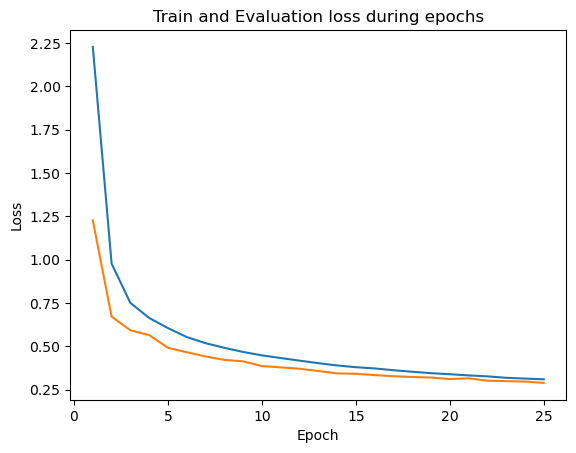

In [36]:
X = list(range(1, len(eval_losses)+1))

plt.plot(X,train_losses)
plt.plot(X,eval_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Evaluation loss during epochs")

### Overfitting fixed when adding dropouts, lower evalutation losses. Probably same accuracy at 88% even adding two conv layers and one more 1d layer. Keep in mind I also added another max pooling.

In [37]:
fmodel.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [38]:
def test():

    prediction_list = []
    test_losses = []
    correct = 0
    test_loss = 0

    fmodel.eval()

    with torch.no_grad():
        for data, target in test_loader:
            output = fmodel(data)
#             prediction = output.max(1 , keepdim = True)[1]
            prediction = output.argmax(dim=1, keepdim=True).squeeze()
            prediction_list.append(prediction)
            correct +=(prediction == target).sum().item()

            #loss summatory for Average loss
            test_loss += criterion(output, target)

        accuracy = correct/10000
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print("/nEval: Average loss: {:.4f},\tAccuracy: {}/{} ({:.0f}%)".format(sum(test_losses), correct, 10000, accuracy * 100))


In [34]:
test()

/nEval: Average loss: 0.3301,	Accuracy: 8781/10000 (88%)


# **Things to include**
## - Batch normalization
## - Image transformation
## - Leaky Relu or Elu activation functions
## - early stoppage